# Part 2: Variable and data creation
## Dependencies: ffmpeg moviepy scipy librosa



In [1]:
#audio
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [2]:
import pandas as pd 
import pyloudnorm as pyln

In [3]:
#video
import moviepy
from moviepy.editor import *

In [4]:
#importing audio
#x1 waveform 
#fs sampling rate

In [5]:
file_dir_list=["Mistborn E0 - Scott.wav", "Mistborn E0 - Zack.wav"]



In [6]:
AUDIO_VIDEO_TUPLE_LIST=[("Mistborn E0 - Scott.wav", 1), ("Mistborn E0 - Zack.wav",2)]

In [7]:
VIDEO_FILEPATH_LIST= ["Middle View.mp4","Scott View.mp4","Zack View.mp4"]

## Creating Data for each Microphone


In [8]:
#importing video and its audio
def dataframecreation(file_dir_list,rate):
    df_list=[]
    instance=1
    for file_dir in file_dir_list:
        data1, rate1 = librosa.load(file_dir, sr=48000) 
        data= librosa.resample(data1, orig_sr=rate1, target_sr=rate, scale=True)

        # peak normalize audio to -1 dB
        peak_normalized_audio = pyln.normalize.peak(data, -1.0)

        # measure the loudness first 
        meter = pyln.Meter(rate) # create BS.1770 meter
        loudness = meter.integrated_loudness(data)

        # loudness normalize audio to -12 dB LUFS
        audio_data_df = pd.DataFrame(pyln.normalize.loudness(data, loudness, -20.0)).rename(columns={0:str(instance)})
        df_list.append(audio_data_df)
        instance=instance+1
    return(df_list)

In [9]:
def doublerollingaverage1(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2*rate)
        rollingaverage_df=df.abs().rolling(indexer).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

In [10]:
def doublerollingaverage(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        rollingaverage_df=df.abs().rolling(rate*5,center=True).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

# Exploration, Lag testing

In [11]:
rate=500 #samples per sec

In [12]:
df_list=dataframecreation(file_dir_list,rate)

In [14]:
df_list

[                   1
 0      -8.583030e-20
 1       7.525326e-20
 2      -1.242618e-20
 3      -8.817497e-20
 4       2.293777e-20
 ...              ...
 551995  2.006790e-04
 551996 -2.872511e-05
 551997 -1.714906e-04
 551998 -1.579283e-04
 551999  1.740260e-04
 
 [552000 rows x 1 columns],
                    2
 0       5.700026e-20
 1       1.223420e-19
 2      -3.083903e-19
 3      -3.934073e-19
 4      -3.587486e-19
 ...              ...
 551995  1.696586e-04
 551996  1.833975e-04
 551997 -1.156400e-03
 551998 -1.367880e-03
 551999  8.983410e-04
 
 [552000 rows x 1 columns]]

In [15]:
dra_df_list=doublerollingaverage(df_list,rate)

# Exhibit A: blue laughs while orange is talking. at 2:02. Speaker shifts at around 2:30.5 and 2:53

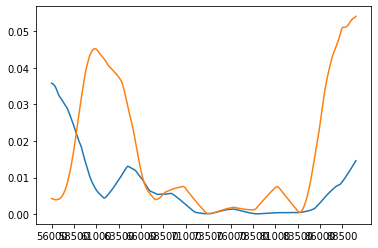

In [16]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[112*rate:3*60*rate])
    plt.xticks(np.arange(112*rate, 3*60*rate+1,  5*rate))


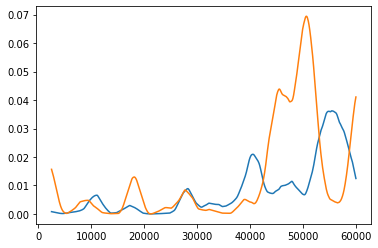

In [19]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[0*rate:120*rate])



### with no lookahead bias, changes speaker  2:30
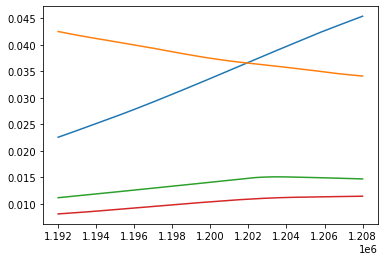![image-2.png](attachment:image-2.png

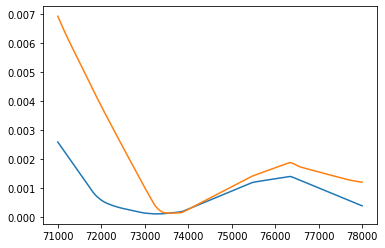

In [20]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[142*rate:156*rate])



In [21]:
172550/rate

345.1

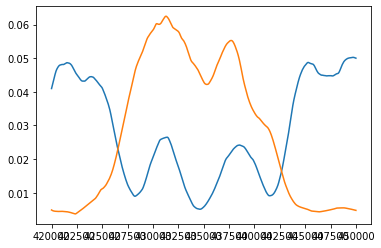

In [23]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[14*60*rate:15*60*rate])
    plt.xticks(np.arange(14*60*rate, 15*60*rate+1,  5*rate))


## with lookahead bias changes speaker at around 2:28.875
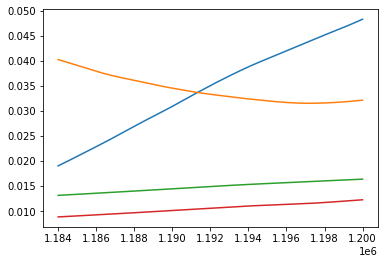


# Exhibit B: Blue is talking but Orange overtakes despite not talking 8:25-8:30

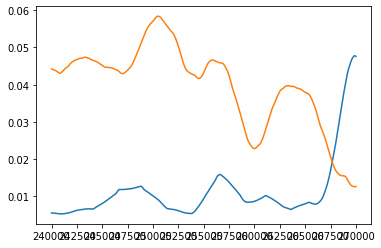

In [24]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[8*60*rate:9*60*rate])
    plt.xticks(np.arange(8*60*rate, 9*60*rate+1,  5*rate))


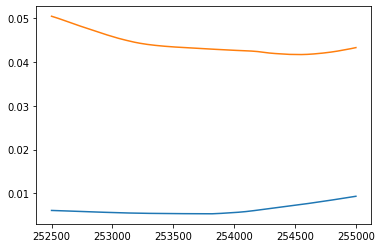

In [25]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[505*rate:510*rate])
 


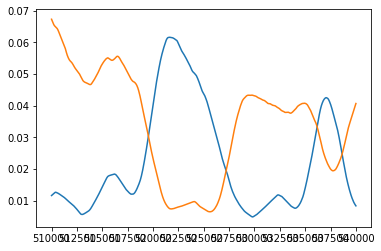

In [26]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[17*60*rate:18*60*rate])
    plt.xticks(np.arange(17*60*rate, 18 *60*rate+1,  5*rate))


# Sampler testing
## 1000
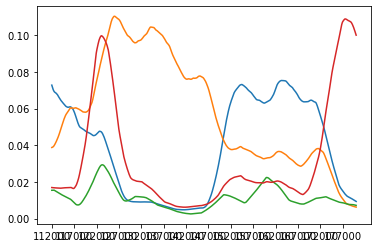
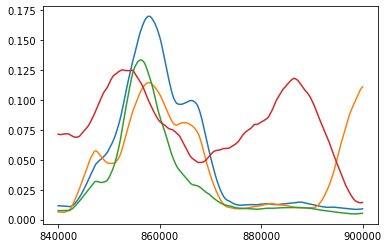
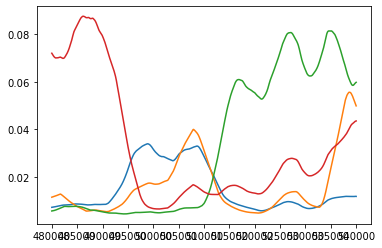
## 500
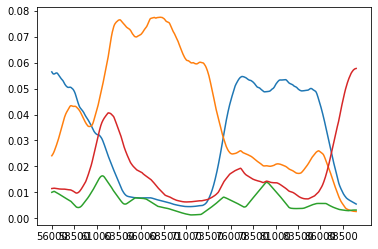
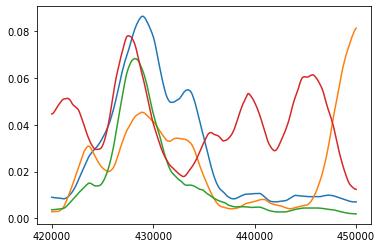
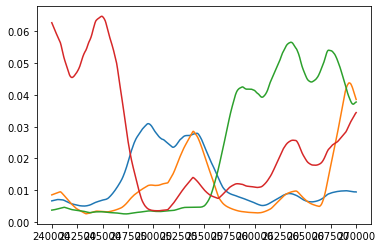


## 250
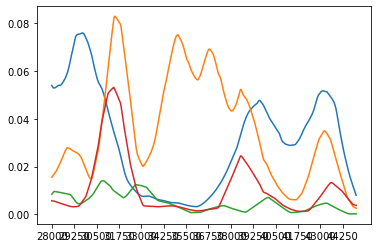
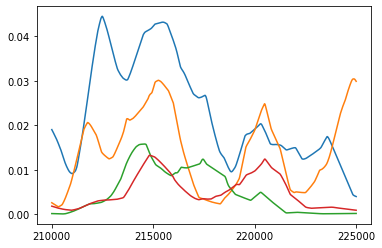
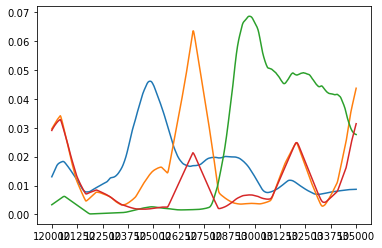

# Testing the logics, Creating speaking intervals

In [20]:
import dtale

In [30]:
#combine dfs first
combined_df=pd.concat(dra_df_list,axis=1)
#this why sync is important so that the rows are exactly aligned

In [27]:
#create list of string to call for each audio file. Used to call the audio name
list_str_audio_thresholds=[]

#for each audio element, create a new list
#each audio file is identified by its place in the tuple
for irow in range(len(AUDIO_VIDEO_TUPLE_LIST)):
    varname="A"
    exec(f"{varname}{irow} = []")
    
    
    list_str_audio_thresholds.append(varname+str(irow))

In [31]:
tests=combined_df.loc[12000]

In [32]:
#testing loop
for i in range(len(tests.values)):
    if tests.values[i]>.0015 :
        eval(list_str_audio_thresholds[i]).append(1)

    else:
        eval(list_str_audio_thresholds[i]).append(0)

## Creating indicators: marking areas of significance

In [22]:
#Loop logic : playing it safe
frames_list=[]
largestindex_list=[]
crossover_list=[]
high_multiplethreshold_list=[]
similarloudness_list=[]

for irow in range(len(combined_df)):
    #creating variables to call

    #more efficient to call variable than constant function calling
    nlargest=combined_df.loc[irow].nlargest(2)
    idxmax=combined_df.loc[irow].idxmax()
    if irow !=0:
        prev_idxmax=combined_df.loc[irow-1].idxmax()
    
    if pd.notna(combined_df.loc[irow].idxmax())==True:
        
        #largest value index
        frames_list.append(int(idxmax))
        
        #indicators
        
        #crossover
        if combined_df.loc[irow].idxmax() != combined_df.loc[irow-1].idxmax():
            crossover_list.append(1)
        else:
            crossover_list.append(0)
            
            
        # multiple above threshold .035
        if nlargest[1]> .035:
            high_multiplethreshold_list.append(1)
        else:
            high_multiplethreshold_list.append(0)
            
        if nlargest[0]< .035:
            low_multiplethreshold_list.append(1)
        else:
            low_multiplethreshold_list.append(0)
            
        
        #similar loudness
        if nlargest[0]-nlargest[1] <.007:
            similarloudness_list.append(1)
        else:
            similarloudness_list.append(0)
    else:
        frames_list.append(0)
        crossover_list.append(0)
        multiplethreshold_list.append(0)
        similarloudness_list.append(0)
    
#if there is another crossover within  6 secs after crossover, maintain center cam 

 


In [23]:
test=pd.DataFrame({"idxmax":frames_list,"crossover":crossover_list,"mult_thresh":multiplethreshold_list,"nearnesssound":similarloudness_list})

In [ ]:
test['cam_view']= test['idxmax'].apply(lambda row: AUDIO_VIDEO_TUPLE_LIST[row-1][1] if row!=0 else 0)

In [42]:
test.to_pickle("idxmax.pkl")

In [25]:
dtale.show(test)

In [26]:
type(test.loc[12000]['idxmax'])

numpy.int64

# Exploring the times where events occur



## Crossover list

In [27]:
test['crossover'].index[test['crossover']==1].to_series()

2500        2500
5408        5408
11597      11597
14939      14939
21558      21558
           ...  
637253    637253
639049    639049
648956    648956
649581    649581
649677    649677
Length: 86, dtype: int64

In [28]:
#for every  index, create a interval index adding 2 seconds of default cam

## Turn continuous values into a list of tuples: where each tuple represents the start and end indexes of continuous True intervals. These intervals will eventually be turned into seconds in the final stage.

### Explanation of function: first finds the indexes of a query and turn it into a pd series

In [29]:
def dataframe_getintervals(series,desiredvalue):
    #make sure series is the df['column']
    t=series.index[series==desiredvalue].to_series()
    interval_list=t.groupby(t.diff().ne(1).cumsum()).agg(['first','last']).apply(tuple,1).tolist()
    
    return interval_list

In [30]:
t=test['nearnesssound'].index[test['nearnesssound']==1].to_series()

In [31]:
intervallist=t.groupby(t.diff().ne(1).cumsum()).agg(['first','last']).apply(tuple,1).tolist()

In [32]:
intervallist_near=dataframe_getintervals(test['nearnesssound'],1)

In [33]:
intervallist_mult=dataframe_getintervals(test['mult_thresh'],1)

In [34]:
too_short=0
too_near=0
for i in range(len(intervallist_mult)):
    value=intervallist[i][1]+rate*3
    
    if intervallist[i][0]+2*rate > intervallist[i][1]:
        too_short=too_short+1
    if i==len(intervallist)-1:
        pass
    
    else: 
        if value > intervallist[i+1][0]:
            too_near=too_near+1

In [35]:
too_near

6

In [36]:
too_short

25

In [37]:
i

35

In [38]:
intervallist[0][0]+rate < intervallist[0][1]

True

In [39]:
intervallist[0][1]

7682

## Testing pandas intervalindex

## Setup Logic 1: Safe, crossover, threshold and nearness

In [40]:
#Priority from least to greatest 
#highest priority set last to override



#1 current loudest: set the current loudest as the camera, sets the skeletal outline of the default timeline
#the only loop 
outline=test['idxmax']


#2 nearness with no crossover nearby next one second (not implemented for now)
#if nearness, check if near crossover within 3 seconds, if no crossover, set camera to default for interval+1 second ahead. 
#outline2=outline


#3 multiple with threshold
#Where there are multiple mics above threshold, set camera to default for interval and 1 second ahead. 




#4 crossover gives 3 seconds
#see all crossovers, add three seconds of default cam



#if crossovers occur, play center cam for three seconds and then maintain loudest speaker


    #if there is a second speaker near the same loudness BUT A CROSSOVER DOES NOT OCCUR IN THE NEXT 3 Secs
    #change to center cam for 3 seconds 



## Seeing Logic differences speaker and listener transition

## Creating the XML file

In [41]:
nlargest

Series([], Name: 653903, dtype: float64)